# ECE 661 FINAL PROJECT: DIRAC GAN IMPLEMENTATION

### IMPORTS

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import os
from os import path
from tqdm import tqdm

### Utility Functions:
- `sigmoid(x)`: Implements the sigmoid activation function which is crucial in neural processes.
- `clip(x, clipval)`: Ensures that `x` remains within the range specified by `clipval`, useful for maintaining numerical stability.


In [2]:
def sigmoid(x):
    m = np.minimum(0, x)
    return np.exp(m)/(np.exp(m) + np.exp(-x + m))


def clip(x, clipval=0.3):
    x = np.clip(x, -clipval, clipval)
    return x

## SETUP
### VectorField
The `VectorField` class is designed to model dynamic systems and lays out the core functionalities needed to calculate vector transformations based on inputs, enabling simulations of how different GAN architectures update their parameters during training.

- `__call__(self, theta, psi)`: This method is called whenever an instance of `VectorField` is used as a function. It handles input parameters `theta` and `psi`, which represent the state variables in our GAN models. The method checks if these inputs are scalar (float) values and converts them to NumPy arrays for vectorized operations. It then computes the vector components (`v1`, `v2`) by calling the `_get_vector` method (which is defined separately in each subclass) and adjusts the output format based on the input type (scalar or array).

- `postprocess(self, theta, psi)`: After updating the state variables (`theta`, `psi`), this method is used to apply any necessary post-processing steps (defined in `_postprocess` method of subclasses). This could involve tasks like clipping values to prevent exploding gradients in certain GAN models. Similar to `__call__`, it ensures that output types are consistent with input types (scalar or array).

- `step_sizes(self, h)`: A simple utility method to determine the step sizes for both variables in simulations, often set equally but customizable depending on specific needs of a GAN architecture.

### Virtual Methods

- `_get_vector(self, theta, psi)`: This abstract method must be implemented by all subclasses. It defines how the vector components (`v1`, `v2`) are calculated. The specific implementation depends on the type of GAN being simulated, which influences how the gradients are computed during the training process.

- `_postprocess(self, theta, psi)`: Another abstract method that allows for additional modifications of the state variables (`theta`, `psi`) after the basic vector computation. Implementations vary among subclasses depending on their specific post-processing needs, such as value clipping in WGANs to enforce Lipschitz constraints.

#### Subclass Implementations
- each has unique transformations (`_get_vector`) to model different types of networks.
1. **Standard GAN (`GAN` class)**:
   - Computes vector components using default functions for modeling training dynamics between generator and discriminator.

2. **Wasserstein GAN (`WGAN` class)**:
   - Includes clipping of the discriminator weights as a post-processing step to satisfy the Lipschitz condition (comment on theorhetical guarantees)

3. **Gradient Penalty GAN (`WGAN_GP` class)**:
   - Adjusts vector components by penalizing the norm of the gradient of the discriminator to enforce a soft version of the Lipschitz constraint.

In [3]:
class VectorField(object):
    def __call__(self, theta, psi):
        theta_isfloat = isinstance(theta, float)
        psi_isfloat = isinstance(psi, float)
        if theta_isfloat:
            theta = np.array([theta])
        if psi_isfloat:
            psi = np.array([psi])

        v1, v2 = self._get_vector(theta, psi)

        if theta_isfloat:
            v1 = v1[0]
        if psi_isfloat:
            v2 = v2[0]

        return v1, v2

    def postprocess(self, theta, psi):
        theta_isfloat = isinstance(theta, float)
        psi_isfloat = isinstance(psi, float)
        if theta_isfloat:
            theta = np.array([theta])
        if psi_isfloat:
            psi = np.array([psi])
        theta, psi = self._postprocess(theta, psi)
        if theta_isfloat:
            theta = theta[0]
        if psi_isfloat:
            psi = psi[0]

        return theta, psi

    def step_sizes(self, h):
        return h, h

    def _get_vector(self, theta, psi):
        raise NotImplemented

    def _postprocess(self, theta, psi):
        return theta, psi


# GANs
def fp(x):
    return sigmoid(-x)


def fp2(x):
    return -sigmoid(-x) * sigmoid(x)


class GAN(VectorField):
    def _get_vector(self, theta, psi):
        v1 = -psi * fp(psi*theta)
        v2 = theta * fp(psi*theta)
        return v1, v2


class NSGAN(VectorField):
    def _get_vector(self, theta, psi):
        v1 = -psi * fp(-psi*theta)
        v2 = theta * fp(psi*theta)
        return v1, v2


class WGAN(VectorField):
    def __init__(self, clip=0.3):
        super().__init__()
        self.clip = clip

    def _get_vector(self, theta, psi):
        v1 = -psi
        v2 = theta

        return v1, v2

    def _postprocess(self, theta, psi):
        psi = clip(psi, self.clip)
        return theta, psi


class WGAN_GP(VectorField):
    def __init__(self, reg=1., target=0.3):
        super().__init__()
        self.reg = reg
        self.target = target

    def _get_vector(self, theta, psi):
        v1 = -psi
        v2 = theta - self.reg * (np.abs(psi) - self.target) * np.sign(psi)
        return v1, v2

### Simulation
Simulation Functions:
- `trajectory_simgd` and `trajectory_altgd`: Simulate the optimization process for GANs using specified update rules and step sizes.


In [4]:
def trajectory_simgd(vec_fn, theta0, psi0,
                     nsteps=50, hs_g=0.1, hs_d=0.1):
    theta, psi = vec_fn.postprocess(theta0, psi0)
    thetas, psis = [theta], [psi]

    if isinstance(hs_g, float):
        hs_g = [hs_g] * nsteps
    if isinstance(hs_d, float):
        hs_d = [hs_d] * nsteps
    assert(len(hs_g) == nsteps)
    assert(len(hs_d) == nsteps)

    for h_g, h_d in zip(hs_g, hs_d):
        v1, v2 = vec_fn(theta, psi)
        theta += h_g * v1
        psi += h_d * v2
        theta, psi = vec_fn.postprocess(theta, psi)
        thetas.append(theta)
        psis.append(psi)

    return thetas, psis


def trajectory_altgd(vec_fn, theta0, psi0,
                     nsteps=50, hs_g=0.1, hs_d=0.1, gsteps=1, dsteps=1):
    theta, psi = vec_fn.postprocess(theta0, psi0)
    thetas, psis = [theta], [psi]

    if isinstance(hs_g, float):
        hs_g = [hs_g] * nsteps
    if isinstance(hs_d, float):
        hs_d = [hs_d] * nsteps
    assert(len(hs_g) == nsteps)
    assert(len(hs_d) == nsteps)

    for h_g, h_d in zip(hs_g, hs_d):
        for it in range(gsteps):
            v1, v2 = vec_fn(theta, psi)
            theta += h_g * v1
            theta, psi = vec_fn.postprocess(theta, psi)

        for it in range(dsteps):
            v1, v2 = vec_fn(theta, psi)
            psi += h_d * v2
            theta, psi = vec_fn.postprocess(theta, psi)
        thetas.append(theta)
        psis.append(psi)

    return thetas, psis

### PLOTTING
- Functions like `arrow_plot` and `vector_field_plot` are used to visualize trajectories and vector fields

In [5]:
def arrow_plot(x, y, color='darkblue'):
    plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1],
               color=color, scale_units='xy', angles='xy', scale=1)

def vector_field_plot(theta, psi, v1, v2, trajectory=None, clip_y=None, marker='--', linewidth=2, dash_pattern=(3, 5)):
    plt.quiver(theta.flatten(), psi.flatten(), v1.flatten(), v2.flatten(), color='darkblue', label='Vector Field')
    if clip_y is not None:
        plt.axhspan(np.min(psi), -clip_y, facecolor='0.2', alpha=0.5)
        plt.plot([np.min(theta), np.max(theta)], [-clip_y, -clip_y], 'k-')
        plt.axhspan(clip_y, np.max(psi), facecolor='0.2', alpha=0.5)
        plt.plot([np.min(theta), np.max(theta)], [clip_y, clip_y], 'k-')


    if trajectory is not None:
        psis, thetas = trajectory
        plt.plot(psis, thetas, linestyle=marker, linewidth=linewidth, dashes=dash_pattern, color='darkorange', label='Trajectory')
        plt.plot(psis[0], thetas[0], 'ro', label='Start Point')

    plt.xlim(np.min(theta), np.max(theta))
    plt.ylim(np.min(psi), np.max(psi))
    plt.xlabel(r'$\theta$ (Generator Parameters)')
    plt.ylabel(r'$\psi$ (Discriminator Parameters)')
    plt.xticks(np.linspace(np.min(theta), np.max(theta), 5))
    plt.yticks(np.linspace(np.min(psi), np.max(psi), 5))
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, fontsize='small', ncol=3, mode="expand", borderaxespad=0)



def plot_vector(vecfn, theta, psi, outfile, trajectory=None, marker='--', title=""):
    fig, ax = plt.subplots(1, 1)
    theta, psi = np.meshgrid(theta, psi)
    v1, v2 = vecfn(theta, psi)
    if isinstance(vecfn, WGAN):
        clip_y = vecfn.clip
    else:
        clip_y = None
    vector_field_plot(theta, psi, v1, v2, trajectory, clip_y=clip_y, marker=marker)
    plt.title(title, pad=35)
    plt.savefig(outfile, bbox_inches='tight')
    plt.show()


def simulate_trajectories(vecfn, theta, psi, trajectory, outfolder, title="", maxframes=300):
    if not os.path.exists(outfolder):
        os.makedirs(outfolder)
    theta, psi = np.meshgrid(theta, psi)
    
    N = min(len(trajectory[0]), maxframes)

    v1, v2 = vecfn(theta, psi)
    if isinstance(vecfn, WGAN):
        clip_y = vecfn.clip
    else:
        clip_y = None

    for i in tqdm(range(1, N)):
        fig, (ax1, ax2) = plt.subplots(1, 2,
                                       subplot_kw=dict(adjustable='box', aspect=0.7))

        plt.sca(ax1)
        trajectory_i = [trajectory[0][:i], trajectory[1][:i]]
        vector_field_plot(theta, psi, v1, v2, trajectory_i, clip_y=clip_y, marker='--')
        plt.plot(trajectory_i[0][-1], trajectory_i[1][-1], 'darkorange', marker='o')

        plt.sca(ax2)
        ax2.set_axisbelow(True)
        plt.grid()

        x = np.linspace(np.min(theta), np.max(theta))
        y = x*trajectory[1][i]
        plt.plot(x, y, 'C1')

        ax2.add_patch(patches.Rectangle(
                (-0.05, 0), .1, 2.5, facecolor='C2'
        ))

        ax2.add_patch(patches.Rectangle(
                (trajectory[0][i]-0.05, 0), .1, 2.5, facecolor='C0'
        ))

        plt.xlim(np.min(theta), np.max(theta))
        plt.ylim(-1, 3.)
        plt.xlabel(r'$\theta$')
        plt.xticks(np.linspace(np.min(theta), np.max(theta), 5))
        ax2.set_yticklabels([])

        plt.title(title)
        plt.savefig(os.path.join(outfolder, '%06d.png' % i), dpi=200, bbox_inches='tight')
        plt.close()

### IMPLEMENTATION
- Executes GAN models using previously defined functions and classes to simulate and plot their behavior under various settings.

In [6]:
h = 0.2
theta0 = 1.
psi0 = 1.
theta_s = np.linspace(-2, 2, 20)
psi_s = np.linspace(-2, 2, 20)

plot_configs = [
    (GAN(), 'gan', h, h, 500, "Static Representation of Vector Fields and Potential Paths for GAN Training", "Simulation of Parameter Updates in NSGAN Training"),
    (NSGAN(), 'nsgan', h, h, 500, "Static Representation of Vector Fields and Potential Paths for NSGAN Training", "Simulation of Parameter Updates in NSGAN Training"),
    (WGAN(1.), 'wgan', h, h, 500, "Static Representation of Vector Fields and Potential Paths for WGAN Training", "Simulation of Parameter Updates in WGAN Training"),
    (WGAN_GP(0.7, 1.), 'wgan_gp', h, h, 500, "Static Representation of Vector Fields and Potential Paths for WGAN-GP Training", "Simulation of Parameter Updates in WGAN-GP Training"),
]


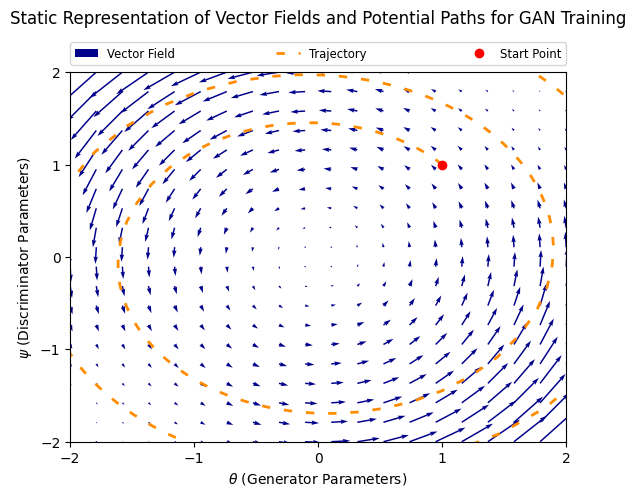

100%|██████████| 299/299 [00:54<00:00,  5.48it/s]


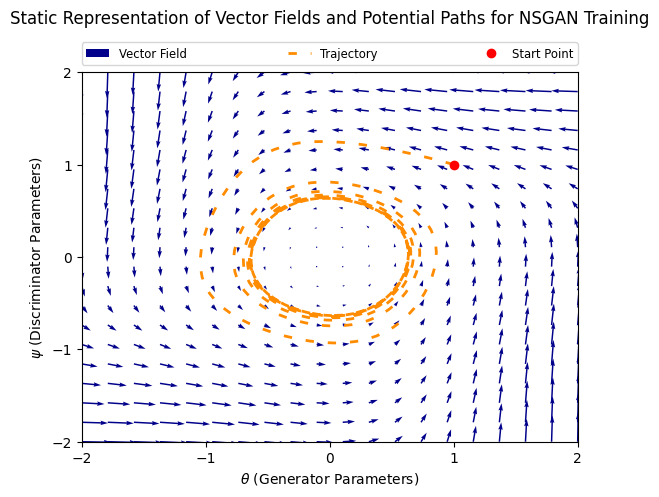

100%|██████████| 299/299 [00:49<00:00,  6.00it/s]


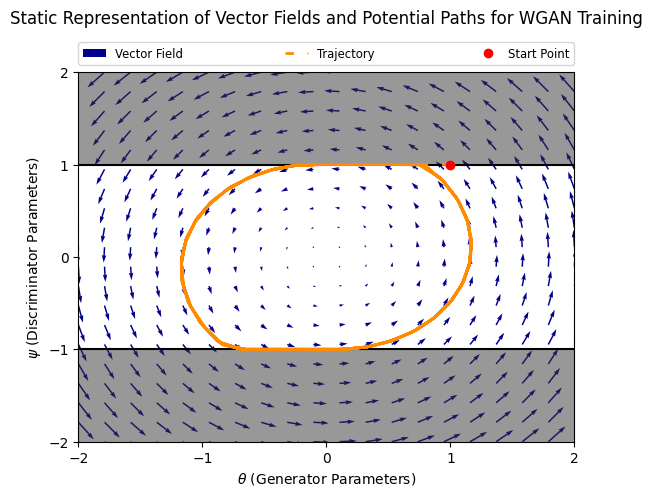

100%|██████████| 299/299 [00:53<00:00,  5.61it/s]


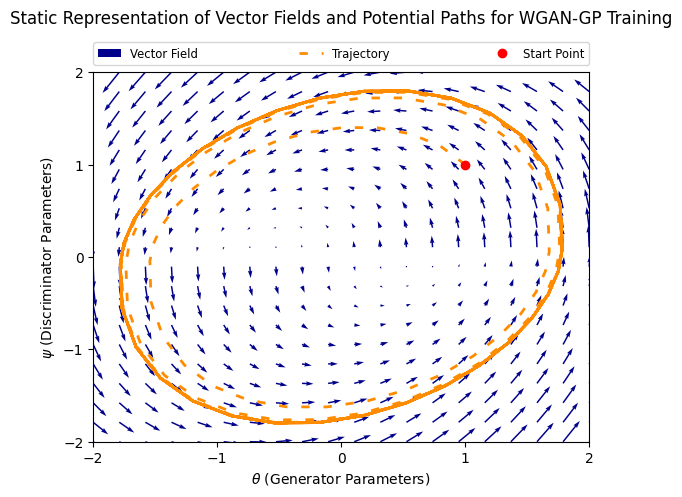

100%|██████████| 299/299 [00:54<00:00,  5.46it/s]


In [7]:
outfolder = './out/simgd'
if not path.exists(outfolder):
    os.makedirs(outfolder)
        
for gan, outfile, hs_g, hs_d, nsteps, vectorTitle, dynamicTitle, in plot_configs:
    trajectory = trajectory_simgd(gan, theta0, psi0, hs_g=hs_g, hs_d=hs_d, nsteps=500)
    plot_vector(gan, theta_s, psi_s, path.join(outfolder, '%s.png' % outfile), trajectory, title=vectorTitle)
    simulate_trajectories(gan, theta_s, psi_s, trajectory, path.join(outfolder, 'animations', outfile), title=dynamicTitle)

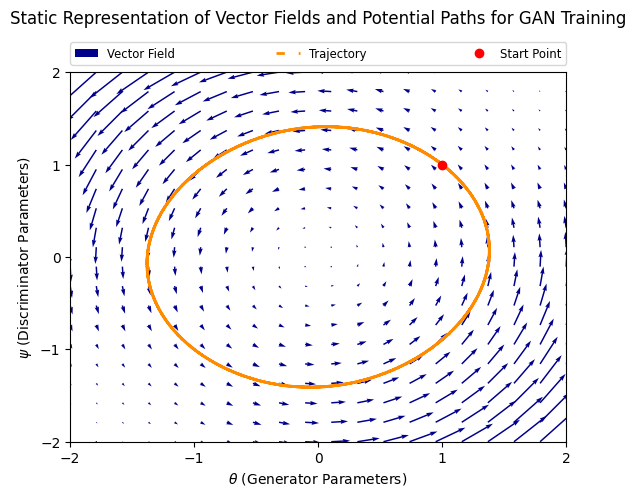

100%|██████████| 299/299 [00:51<00:00,  5.81it/s]


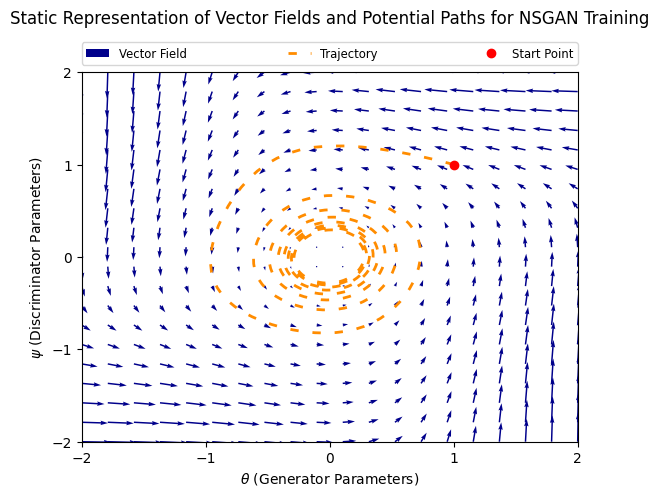

100%|██████████| 299/299 [00:49<00:00,  6.06it/s]


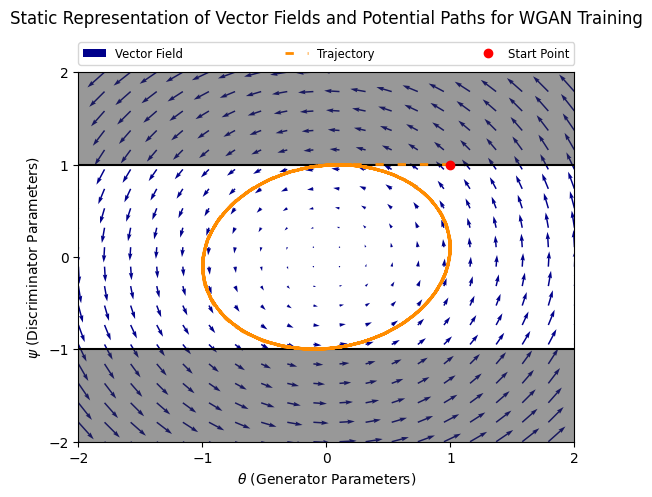

100%|██████████| 299/299 [00:49<00:00,  6.03it/s]


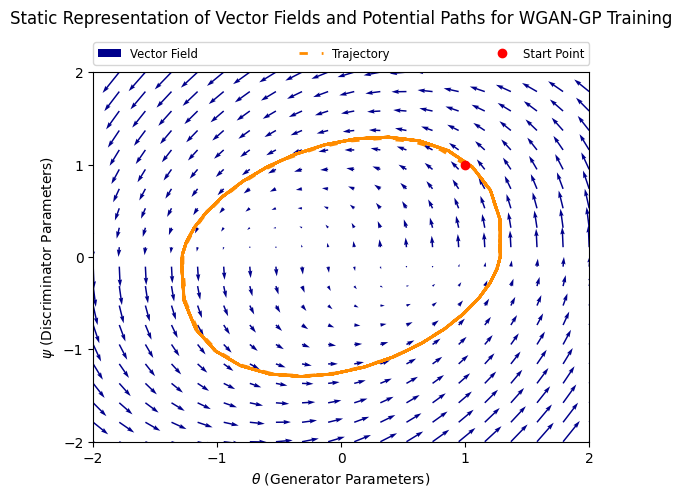

100%|██████████| 299/299 [00:50<00:00,  5.97it/s]


In [8]:
outfolder = './out/altgd1'
if not path.exists(outfolder):
    os.makedirs(outfolder)
    
for gan, outfile, hs_g, hs_d, nsteps, vectorTitle, dynamicTitle, in plot_configs:
    trajectory = trajectory_altgd(gan, theta0, psi0, hs_g=hs_g, hs_d=hs_d, nsteps=nsteps, dsteps=1)
    plot_vector(gan, theta_s, psi_s, path.join(outfolder, outfile), trajectory, title=vectorTitle)
    simulate_trajectories(gan, theta_s, psi_s, trajectory, path.join(outfolder, 'animations', outfile), title=dynamicTitle)

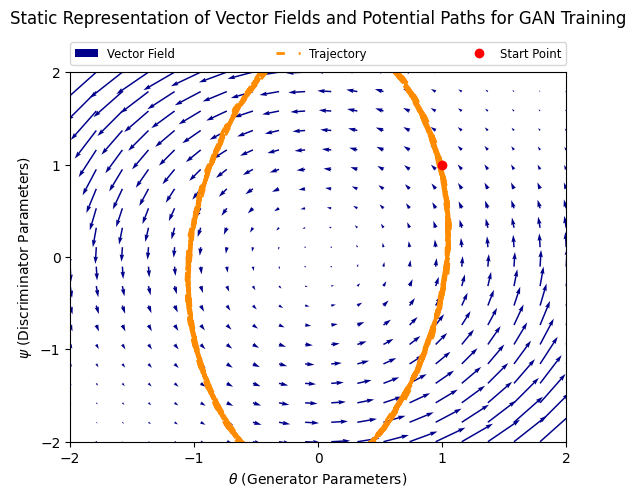

100%|██████████| 299/299 [00:51<00:00,  5.76it/s]


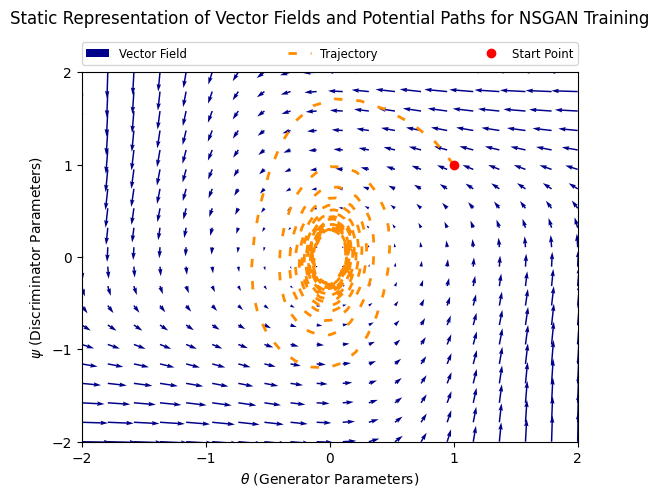

100%|██████████| 299/299 [00:51<00:00,  5.84it/s]


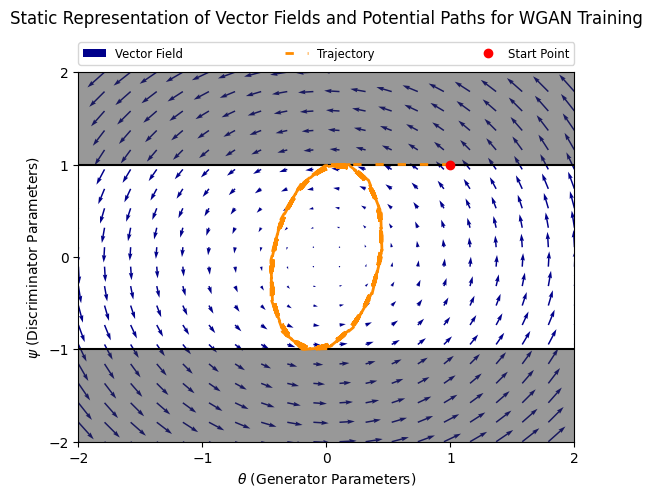

100%|██████████| 299/299 [00:54<00:00,  5.51it/s]


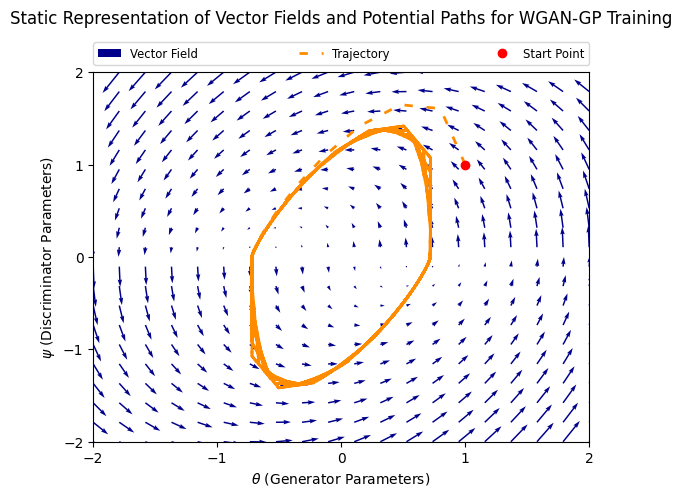

100%|██████████| 299/299 [00:52<00:00,  5.71it/s]


In [9]:
outfolder = './out/altgd5'
if not path.exists(outfolder):
    os.makedirs(outfolder)
    
for gan, outfile, hs_g, hs_d, nsteps, vectorTitle, dynamicTitle, in plot_configs:
    trajectory = trajectory_altgd(gan, theta0, psi0, hs_g=hs_g, hs_d=hs_d, nsteps=nsteps, dsteps=5)
    plot_vector(gan, theta_s, psi_s, path.join(outfolder, outfile), trajectory, title=vectorTitle)
    simulate_trajectories(gan, theta_s, psi_s, trajectory, path.join(outfolder, 'animations', outfile), title=dynamicTitle)

### Eigenvalue Visualization in the Complex Plane

#### Setup
- Font size set to 18 for clarity (`matplotlib.rcParams.update`).
- Two eigenvalue ranges defined (`f0 = 1/2`):
  - `reg_0`: Eigenvalues from 0 to `f0` (20 points).
  - `reg_1`: Eigenvalues from `2*f0` to `3*f0` (20 points).

#### Eigenvalue Calculations
- **First Set (`_0`)**: Symmetric eigenvalues about the real axis.
  - Real parts: `real1_0`, `real2_0`
  - Imaginary parts: `imag1_0` (positive), `imag2_0` (negative)
- **Second Set (`_1`)**: Purely real eigenvalues indicating different stability conditions.
  - Real shifts and scaling: `real1_1`, `real2_1`
  - Imaginary parts are zero: `imag1_1`, `imag2_1`

#### Plotting
- Arrows represent trajectories of eigenvalues (`arrow_plot`).
- Key points marked with blue circles (`plt.plot`), highlighting critical values like start and end points.
- Grid and labels enhance readability; real and imaginary axes are labeled.
- Annotations (`plt.text`) use LaTeX for clear mathematical representation, marking critical gamma values.

#### Output
- Plot dimensions set for good visibility (`fig.set_size_inches`).
- Saved as PNG (`plt.savefig`) and displayed (`plt.show`).

These notes detail the visualization process for eigenvalues in complex stability analyses, crucial for understanding dynamics in GANs with gradient penalties.

<>:35: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:38: SyntaxWarning: invalid escape sequence '\g'
<>:39: SyntaxWarning: invalid escape sequence '\,'
<>:40: SyntaxWarning: invalid escape sequence '\,'
<>:35: SyntaxWarning: invalid escape sequence '\,'
<>:36: SyntaxWarning: invalid escape sequence '\,'
<>:38: SyntaxWarning: invalid escape sequence '\g'
<>:39: SyntaxWarning: invalid escape sequence '\,'
<>:40: SyntaxWarning: invalid escape sequence '\,'
C:\Users\joshu\AppData\Local\Temp\ipykernel_14560\204726214.py:35: SyntaxWarning: invalid escape sequence '\,'
  plt.text(-0.1, .4, '$0\,\gamma_{\mathrm{critical}}$')
C:\Users\joshu\AppData\Local\Temp\ipykernel_14560\204726214.py:36: SyntaxWarning: invalid escape sequence '\,'
  plt.text(-0.1, -.44, '$0\,\gamma_{\mathrm{critical}}$')
C:\Users\joshu\AppData\Local\Temp\ipykernel_14560\204726214.py:38: SyntaxWarning: invalid escape sequence '\g'
  plt.text(-0.45, .05, '$\gamma_{\mathrm{cr

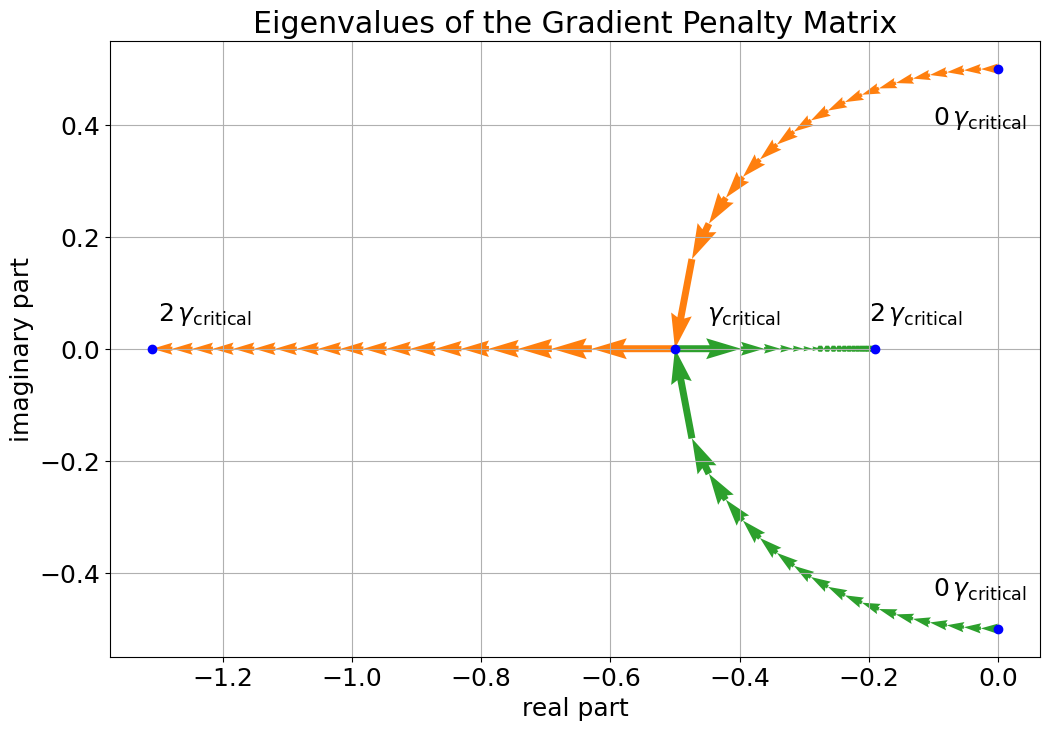

In [10]:
matplotlib.rcParams.update({'font.size': 18})
f0 = 1/2
reg_0 = np.linspace(0, 2*f0, 20)
reg_1 = np.linspace(2*f0, 3*f0, 20)

real1_0 = -reg_0/2
imag1_0 = np.sqrt(f0**2 - reg_0**2/4)
real2_0 = real1_0
imag2_0 = -imag1_0

real1_1 = -reg_1/2 - np.sqrt(reg_1**2/4 - f0**2)
imag1_1 = np.zeros_like(real1_1)
real2_1 = -reg_1/2 + np.sqrt(reg_1**2/4 - f0**2)
imag2_1 = np.zeros_like(real2_1)

real1 = np.concatenate([real1_0, real1_1], axis=0)
real2 = np.concatenate([real2_0, real2_1], axis=0)
imag1 = np.concatenate([imag1_0, imag1_1], axis=0)
imag2 = np.concatenate([imag2_0, imag2_1], axis=0)

fig, ax = plt.subplots()
arrow_plot(real1, imag1, 'C1')
arrow_plot(real2, imag2, 'C2')
plt.plot(real1[0], imag1[0], 'bo')
plt.plot(real2[0], imag2[0], 'bo')

plt.plot([-.5], [-0], 'bo')
plt.plot(real1[-1], imag1[-1], 'bo')
plt.plot(real2[-1], imag2[-1], 'bo')

plt.grid(True)

plt.xlabel('real part')
plt.ylabel('imaginary part')
plt.text(-0.1, .4, '$0\,\gamma_{\mathrm{critical}}$')
plt.text(-0.1, -.44, '$0\,\gamma_{\mathrm{critical}}$')

plt.text(-0.45, .05, '$\gamma_{\mathrm{critical}}$')
plt.text(-1.3, .05, '$2\,\gamma_{\mathrm{critical}}$')
plt.text(-0.2, .05, '$2\,\gamma_{\mathrm{critical}}$')
plt.title('Eigenvalues of the Gradient Penalty Matrix')
fig.set_size_inches(12, 8)
plt.savefig('eigval_gradpen.png', bbox_inches='tight')
plt.show()